# Adult Income Prediction: A Comparative Analysis of Classification Models
- By Varshith Jajula
- NJIT UCID: VJ252

## Importing Libararies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, roc_auc_score, brier_score_loss, confusion_matrix, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

## Loading the data

In [2]:
adult_df = pd.read_csv( "adult.data", sep=",", header = None)

The dataset used for this project is the Adult Income dataset, available at: Adult - UCI Machine Learning Repository. 

Setting the Column Names

In [3]:
column_names = [
    "age", "workclass", "fnlwgt", "education", "education-num",
    "marital-status", "occupation", "relationship", "race", "sex",
    "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"
]
adult_df.columns = column_names


# Understanding the Data


In [4]:
adult_df.head()
print(adult_df['income'].unique())


[' <=50K' ' >50K']


The Target Variable has 2 values [' <=50K' ' >50K'].

In [5]:
for col in ['workclass', 'occupation', 'native-country']:
    adult_df[col].fillna(adult_df[col].mode()[0], inplace=True)

In [6]:
adult_df.isnull().sum()
adult_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [7]:
adult_df['income'] = adult_df['income'].map({' <=50K': 0, ' >50K': 1})
adult_df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


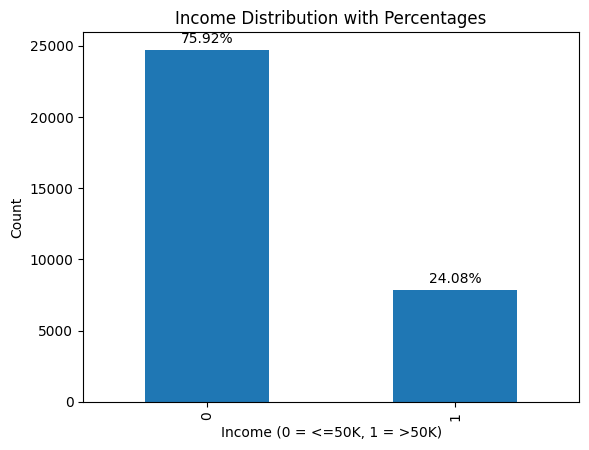

In [8]:
income_counts = adult_df['income'].value_counts()
income_percentages = (income_counts / income_counts.sum()) * 100
fig, ax = plt.subplots()
income_counts.plot(kind='bar', ax=ax)
for i, count in enumerate(income_counts):
    ax.text(i, count + 500, f'{income_percentages[i]:.2f}%', ha='center', fontsize=10)

plt.xlabel('Income (0 = <=50K, 1 = >50K)')
plt.ylabel('Count')
plt.title('Income Distribution with Percentages')
plt.show()


The Distrubution of Target Variable

## Data preprocessing

In [9]:
# Separating Target and Features from the DataFrame
features = adult_df.iloc[:, :-1]
Y = adult_df.iloc[:, -1]

In [10]:
# Checking for Categorical Variables
features_complete= features.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

In [11]:
features_complete

workclass          9
education         16
marital-status     7
occupation        15
relationship       6
race               5
sex                2
native-country    42
dtype: int64

In [12]:
# Label Encoding
le = LabelEncoder()
le_count = 0
encoded_columns = []
for col in features:
    if features[col].dtype == 'object':
        if len(list(features[col].unique())) <= 2:
            le.fit(features[col])
            features[col] = le.transform(features[col])
            le_count += 1
            encoded_columns.append(col)

print('%d columns were label encoded: %s' % (le_count, encoded_columns))

1 columns were label encoded: ['sex']


In [13]:
features_complete = pd.get_dummies(features)
features_complete.head()

,age,fnlwgt,education-num,sex,capital-gain,capital-loss,hours-per-week,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,39,77516,13,1,2174,0,40,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,50,83311,13,1,0,0,13,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,38,215646,9,1,0,0,40,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,53,234721,7,1,0,0,40,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,28,338409,13,0,0,0,40,False,False,False,...,False,False,False,False,False,False,False,False,False,False


By applying label encoding to columns with fewer than two levels, the total
number of columns was reduced, streamlining the model for improved efficiency and performance.








In [14]:
X = features_complete

## Standarization

In [15]:
scaler = StandardScaler()
X[['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']] = scaler.fit_transform(X[['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']])



Here, we are standardizing  numeric columns in the dataset X using StandardScaler. The numeric features are transformed to have a mean of 0 and standard deviation of 1, which can improve the performance of many machine learning algorithms by ensuring all features are on a similar scale.

## Splitting the data for training and testing

In [16]:
# Splitting the data in 70-30 Ratio
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)


X_train shape: (22792, 107)
X_test shape: (9769, 107)
Y_train shape: (22792,)
Y_test shape: (9769,)


# Model Building
1) Random Forest

2) KNN

3) LSTM

In [17]:
from sklearn.metrics import confusion_matrix, accuracy_score

def calculate_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm.ravel()

    # Core metrics
    TPR = TP / (TP + FN) if (TP + FN) != 0 else 0  # True Positive Rate (Recall)
    TNR = TN / (TN + FP) if (TN + FP) != 0 else 0  # True Negative Rate
    FPR = FP / (TN + FP) if (TN + FP) != 0 else 0  # False Positive Rate
    FNR = FN / (TP + FN) if (TP + FN) != 0 else 0  # False Negative Rate
    BACC = (TPR + TNR) / 2  # Balanced Accuracy
    TSS = TPR - FPR  # True Skill Statistic
    HSS = 2 * (TP * TN - FP * FN) / ((TP + FN) * (FN + TN) + (TP + FP) * (FP + TN)) if ((TP + FN) * (FN + TN) + (TP + FP) * (FP + TN)) != 0 else 0  # Heidke Skill Score
    Precision = TP / (TP + FP) if (TP + FP) != 0 else 0  # Precision
    F1_measure = 2 * (Precision * TPR) / (Precision + TPR) if (Precision + TPR) != 0 else 0  # F1 Score
    Accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) != 0 else 0  # Calculated Accuracy
    Error_rate = (FP + FN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) != 0 else 0  # Error Rate
    sklearn_accuracy = accuracy_score(y_true, y_pred)  # Accuracy by sklearn

    return {
        'TP': TP,
        'TN': TN,
        'FP': FP,
        'FN': FN,
        'TPR': TPR,
        'TNR': TNR,
        'FPR': FPR,
        'FNR': FNR,
        'BACC': BACC,
        'TSS': TSS,
        'HSS': HSS,
        'Precision': Precision,
        'F1_measure': F1_measure,
        'Calculated_Accuracy': Accuracy,
        'Error_rate': Error_rate,
        'Sklearn_Accuracy': sklearn_accuracy
    }


In [18]:
knn_parameters = {"n_neighbors": [5, 7, 9, 11, 13, 15, 17, 19, 21]}
knn_model = KNeighborsClassifier()
knn_cv = GridSearchCV(knn_model, knn_parameters, cv=10, n_jobs=-1)
knn_cv.fit(X_train, Y_train)
print("\nBest Parameters for KNN based on GridSearchCV: ", knn_cv.best_params_)
print('\n')
best_n_neighbors = knn_cv.best_params_['n_neighbors']



Best Parameters for KNN based on GridSearchCV:  {'n_neighbors': 21}




### Random Forest

In [19]:
# Params for Random Forest
param_dist_rf = {
    "n_estimators": [50, 100, 150],
    "min_samples_leaf": [1, 2, 4],
    "criterion": ['gini', 'entropy']
}

rf_classifier = RandomForestClassifier()

#RandomizedSearchCV
random_search_rf = RandomizedSearchCV(
    estimator=rf_classifier,
    param_distributions=param_dist_rf,
    n_iter=10,  
    cv=10,
    n_jobs=-1,
    random_state=42
)

# Model Fitting 
random_search_rf.fit(X_train, Y_train)
best_rf_params = random_search_rf.best_params_
print("\nBest Parameters for Random Forest based on RandomizedSearchCV: ", best_rf_params)


Best Parameters for Random Forest based on RandomizedSearchCV:  {'n_estimators': 50, 'min_samples_leaf': 2, 'criterion': 'gini'}


In [20]:
rf_model = RandomForestClassifier(**best_rf_params, random_state=42)
rf_metrics = []
skf = StratifiedKFold(n_splits=10)

# Metric Calculation For Each Fold 
for fold, (train_index, val_index) in enumerate(skf.split(X_train, Y_train), start=1):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = Y_train.iloc[train_index], Y_train.iloc[val_index]

    rf_model.fit(X_train_fold, y_train_fold)
    y_val_pred = rf_model.predict(X_val_fold)
    y_val_prob = rf_model.predict_proba(X_val_fold)[:, 1]
    metrics = calculate_metrics(y_val_fold, y_val_pred)
    metrics['AUC'] = roc_auc_score(y_val_fold, y_val_prob)
    metrics['Brier_Score'] = brier_score_loss(y_val_fold, y_val_prob)
    rf_metrics.append(metrics)

# Average Calcualtion
rf_metrics_df = pd.DataFrame(rf_metrics)
average_rf_metrics = rf_metrics_df.mean().to_frame(name='Average')




In [21]:
print("\nRandom Forest Metrics for Each Fold:\n", rf_metrics_df.T)



Random Forest Metrics for Each Fold:
                                0            1            2            3  \
TP                    336.000000   350.000000   336.000000   328.000000   
TN                   1619.000000  1614.000000  1615.000000  1620.000000   
FP                    108.000000   113.000000   112.000000   107.000000   
FN                    217.000000   203.000000   216.000000   224.000000   
TPR                     0.607595     0.632911     0.608696     0.594203   
TNR                     0.937464     0.934569     0.935148     0.938043   
FPR                     0.062536     0.065431     0.064852     0.061957   
FNR                     0.392405     0.367089     0.391304     0.405797   
BACC                    0.772529     0.783740     0.771922     0.766123   
TSS                     0.545059     0.567480     0.543843     0.532246   
HSS                     0.584197     0.600710     0.581087     0.573605   
Precision               0.756757     0.755940     0.750000   

In [22]:
print("\nRandom Forest Average Metrics across all folds:\n", average_rf_metrics)


Random Forest Average Metrics across all folds:
                          Average
TP                    340.100000
TN                   1623.200000
FP                    103.300000
FN                    212.600000
TPR                     0.615332
TNR                     0.940169
FPR                     0.059831
FNR                     0.384668
BACC                    0.777750
TSS                     0.555501
HSS                     0.595496
Precision               0.767172
F1_measure              0.682788
Calculated_Accuracy     0.861399
Error_rate              0.138601
Sklearn_Accuracy        0.861399
AUC                     0.916502
Brier_Score             0.096530


### KNN Model


In [23]:
# KNN Model Initialization
knn_model = KNeighborsClassifier(n_neighbors=best_n_neighbors)

knn_metrics = []

for fold, (train_index, val_index) in enumerate(skf.split(X_train, Y_train), start=1):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = Y_train.iloc[train_index], Y_train.iloc[val_index]
    knn_model.fit(X_train_fold, y_train_fold)
    y_val_pred = knn_model.predict(X_val_fold)
    y_val_prob = knn_model.predict_proba(X_val_fold)[:, 1]
    metrics = calculate_metrics(y_val_fold, y_val_pred)
    metrics['AUC'] = roc_auc_score(y_val_fold, y_val_prob)
    metrics['Brier_Score'] = brier_score_loss(y_val_fold, y_val_prob)

    knn_metrics.append(metrics)
knn_metrics_df = pd.DataFrame(knn_metrics)
average_knn_metrics = knn_metrics_df.mean().to_frame(name='Average')




In [24]:
print("\nKNN Metrics for Each Fold:\n", knn_metrics_df.T)



KNN Metrics for Each Fold:
                                0            1            2            3  \
TP                    327.000000   331.000000   335.000000   340.000000   
TN                   1576.000000  1586.000000  1590.000000  1578.000000   
FP                    151.000000   141.000000   137.000000   149.000000   
FN                    226.000000   222.000000   217.000000   212.000000   
TPR                     0.591320     0.598553     0.606884     0.615942   
TNR                     0.912565     0.918356     0.920672     0.913723   
FPR                     0.087435     0.081644     0.079328     0.086277   
FNR                     0.408680     0.401447     0.393116     0.384058   
BACC                    0.751943     0.758454     0.763778     0.764833   
TSS                     0.503885     0.516909     0.527556     0.529665   
HSS                     0.528236     0.543992     0.554914     0.551060   
Precision               0.684100     0.701271     0.709746     0.695297

In [25]:
print("\nKNN Average Metrics across all folds:\n", average_knn_metrics)


KNN Average Metrics across all folds:
                          Average
TP                    333.800000
TN                   1582.900000
FP                    143.600000
FN                    218.900000
TPR                     0.603944
TNR                     0.916826
FPR                     0.083174
FNR                     0.396056
BACC                    0.760385
TSS                     0.520770
HSS                     0.546054
Precision               0.699320
F1_measure              0.648075
Calculated_Accuracy     0.840953
Error_rate              0.159047
Sklearn_Accuracy        0.840953
AUC                     0.893400
Brier_Score             0.108880


### LSTM
  

In [26]:
# Reshaping
X_train_reshaped = X_train.values.astype(np.float32).reshape((X_train.shape[0], 1, X_train.shape[1]))
Y_train_reshaped = Y_train.values.astype(np.int32)  

def create_lstm_model():
    model = Sequential()
    model.add(LSTM(50, input_shape=(1, X_train_reshaped.shape[2]), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

lstm_metrics = []

for fold, (train_index, val_index) in enumerate(skf.split(X_train_reshaped, Y_train_reshaped), start=1):
    X_train_fold, X_val_fold = X_train_reshaped[train_index], X_train_reshaped[val_index]
    y_train_fold, y_val_fold = Y_train_reshaped[train_index], Y_train_reshaped[val_index]

    lstm_model = create_lstm_model()
    history = lstm_model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, verbose=0)
    y_val_prob = lstm_model.predict(X_val_fold)
    y_val_pred = (y_val_prob > 0.5).astype("int32")
    metrics = calculate_metrics(y_val_fold, y_val_pred)
    metrics['AUC'] = roc_auc_score(y_val_fold, y_val_prob)
    metrics['Brier_Score'] = brier_score_loss(y_val_fold, y_val_prob)

    lstm_metrics.append(metrics)
lstm_metrics_df = pd.DataFrame(lstm_metrics)
average_lstm_metrics = lstm_metrics_df.mean().to_frame(name='Average')

72/72 [==============================] - 1s 2ms/step


In [27]:
print("\nLSTM Metrics for Each Fold:\n", lstm_metrics_df.T)


LSTM Metrics for Each Fold:
                                0            1            2            3  \
TP                    340.000000   339.000000   385.000000   340.000000   
TN                   1605.000000  1616.000000  1551.000000  1610.000000   
FP                    122.000000   111.000000   176.000000   117.000000   
FN                    213.000000   214.000000   167.000000   212.000000   
TPR                     0.614828     0.613020     0.697464     0.615942   
TNR                     0.929357     0.935727     0.898089     0.932252   
FPR                     0.070643     0.064273     0.101911     0.067748   
FNR                     0.385172     0.386980     0.302536     0.384058   
BACC                    0.772093     0.774373     0.797776     0.774097   
TSS                     0.544185     0.548747     0.595553     0.548194   
HSS                     0.576426     0.585835     0.592268     0.582285   
Precision               0.735931     0.753333     0.686275     0.74398

In [28]:
print("\nLSTM Average Metrics across all folds:\n", average_lstm_metrics)


LSTM Average Metrics across all folds:
                          Average
TP                    350.800000
TN                   1598.200000
FP                    128.300000
FN                    201.900000
TPR                     0.634707
TNR                     0.925688
FPR                     0.074312
FNR                     0.365293
BACC                    0.780197
TSS                     0.560395
HSS                     0.586801
Precision               0.734134
F1_measure              0.679628
Calculated_Accuracy     0.855125
Error_rate              0.144875
Sklearn_Accuracy        0.855125
AUC                     0.913862
Brier_Score             0.098910


### Making Predictions

In [29]:
lstm_model_final = create_lstm_model()
lstm_model_final.fit(X_train_reshaped, Y_train, epochs=10, batch_size=32, verbose=0)

# Reshape test data to match input shape expected by LSTM model
X_test_reshaped = X_test.values.astype(np.float32).reshape((X_test.shape[0], 1, X_test.shape[1]))

y_test_prob = lstm_model_final.predict(X_test_reshaped)

y_test_pred = (y_test_prob > 0.5).astype("int32")

test_metrics = calculate_metrics(Y_test, y_test_pred)

test_metrics['AUC'] = roc_auc_score(Y_test, y_test_prob)
test_metrics['Brier_Score'] = brier_score_loss(Y_test, y_test_prob)

test_metrics_df = pd.DataFrame(test_metrics, index=[0]).T  
test_metrics_df.columns = ["Value"]  
print("\nLSTM Metrics on Test Set:\n", test_metrics_df)

306/306 [==============================] - 1s 3ms/step

LSTM Metrics on Test Set:
                            Value
TP                   1465.000000
TN                   6918.000000
FP                    537.000000
FN                    849.000000
TPR                     0.633103
TNR                     0.927968
FPR                     0.072032
FNR                     0.366897
BACC                    0.780535
TSS                     0.561071
HSS                     0.588427
Precision               0.731768
F1_measure              0.678869
Calculated_Accuracy     0.858123
Error_rate              0.141877
Sklearn_Accuracy        0.858123
AUC                     0.911223
Brier_Score             0.098553


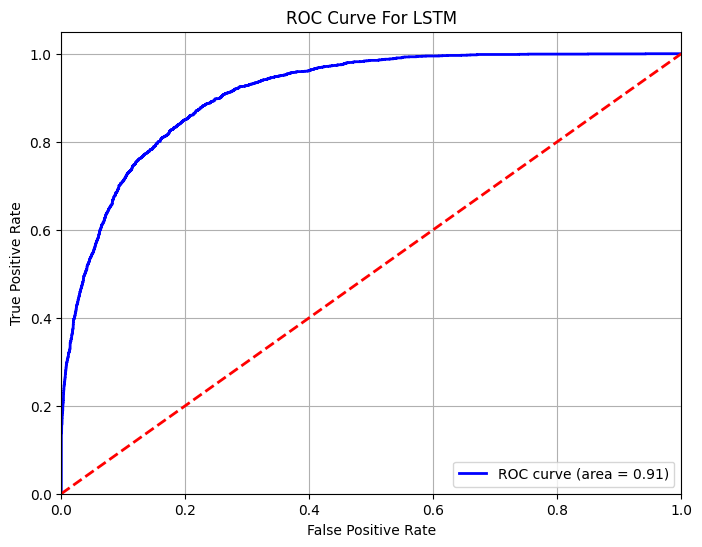

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, y_test_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve For LSTM')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [31]:
rf_model.fit(X_train, Y_train)

y_test_pred = rf_model.predict(X_test)
test_metrics = calculate_metrics(Y_test, y_test_pred)
y_test_prob = rf_model.predict_proba(X_test)[:, 1]
test_metrics['AUC'] = roc_auc_score(Y_test, y_test_prob)
test_metrics['Brier_Score'] = brier_score_loss(Y_test, y_test_prob)
test_metrics_df = pd.DataFrame(test_metrics, index=[0]).T  
test_metrics_df.columns = ["Value"]  
print("\n RF Metrics on Test Set:\n", test_metrics_df)


 RF Metrics on Test Set:
                            Value
TP                   1440.000000
TN                   7002.000000
FP                    453.000000
FN                    874.000000
TPR                     0.622299
TNR                     0.939235
FPR                     0.060765
FNR                     0.377701
BACC                    0.780767
TSS                     0.561534
HSS                     0.599118
Precision               0.760697
F1_measure              0.684573
Calculated_Accuracy     0.864162
Error_rate              0.135838
Sklearn_Accuracy        0.864162
AUC                     0.914348
Brier_Score             0.096325


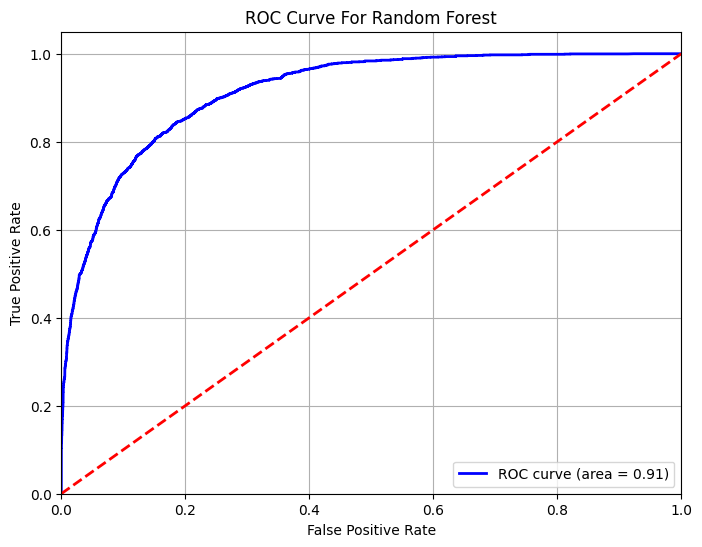

In [32]:
fpr, tpr, threshods = roc_curve(Y_test, y_test_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve For Random Forest')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [33]:
knn_model.fit(X_train, Y_train)
y_test_pred_knn = knn_model.predict(X_test)
test_metrics_knn = calculate_metrics(Y_test, y_test_pred_knn)
y_test_prob_knn = knn_model.predict_proba(X_test)[:, 1]
test_metrics_knn['AUC'] = roc_auc_score(Y_test, y_test_prob_knn)
test_metrics_knn['Brier_Score'] = brier_score_loss(Y_test, y_test_prob_knn)
test_metrics_knn_df = pd.DataFrame(test_metrics_knn, index=[0]).T
test_metrics_knn_df.columns = ["Value"]
print("\nKNN Metrics on Test Set:\n", test_metrics_knn_df)


KNN Metrics on Test Set:
                            Value
TP                   1418.000000
TN                   6843.000000
FP                    612.000000
FN                    896.000000
TPR                     0.612792
TNR                     0.917907
FPR                     0.082093
FNR                     0.387208
BACC                    0.765350
TSS                     0.530699
HSS                     0.554150
Precision               0.698522
F1_measure              0.652855
Calculated_Accuracy     0.845634
Error_rate              0.154366
Sklearn_Accuracy        0.845634
AUC                     0.893203
Brier_Score             0.107271


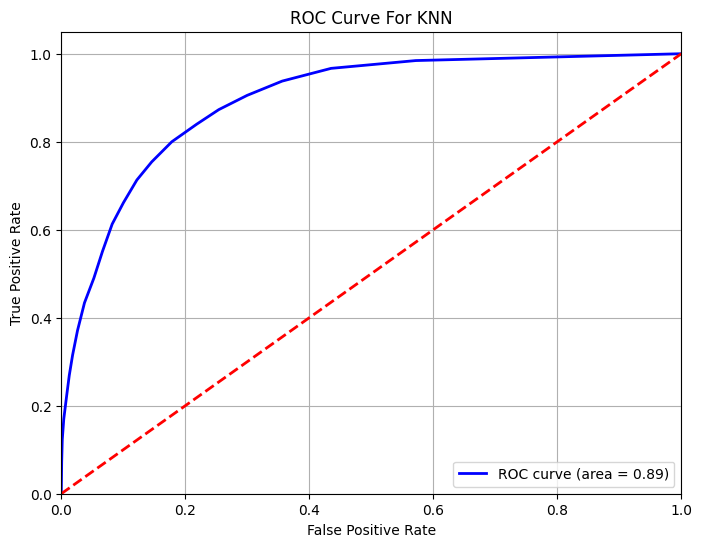

In [34]:
fpr, tpr, thresholds = roc_curve(Y_test, y_test_prob_knn)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve For KNN')
plt.legend(loc='lower right')
plt.grid()
plt.show()